# Food Waste Dataset - Data Cleaning & Feature Engineering

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Change to your own directory
try:
    os.chdir("/content/drive/MyDrive/UAB/FDS/campus-waste-intelligence")
    print("Directory changed")
except OSError:
    print("Error: Can't change the Current Working Directory")

Mounted at /content/drive
Directory changed


In [3]:
df = pd.read_csv('data/food_waste_university_canteen.csv')
df_fw = pd.read_csv('data/food_waste_university_canteen.csv', encoding='latin-1')
df_sc = pd.read_csv('data/data_co_supply_chain_dataset.csv', encoding='latin-1')
df_fao = pd.read_csv('data/data_fao_food_loss_and_waste_database.csv', encoding='latin-1')
df_sc_desc = pd.read_csv('data/description_data_co_supply_chain.csv', encoding='latin-1')
df_weather = pd.read_csv('data/weather_birmingham_35233.csv', encoding='latin-1')

In [4]:
for name, dataframe in {
    "Food Waste": df_fw,
    "Supply Chain": df_sc,
    "FAO": df_fao,
    "Supply Chain Description": df_sc_desc,
    "Weather": df_weather
}.items():

    print(f"\n===== {name} =====")
    print("Shape:", dataframe.shape)
    print("\nFirst 5 rows:")
    print(dataframe.head())
    print("\nData Types:")
    print(dataframe.dtypes)
    print("\nSummary Statistics:")
    print(dataframe.describe(include='all'))


===== Food Waste =====
Shape: (2600, 7)

First 5 rows:
         Date       Meal Canteen_Section Food_Category  Waste_Weight_kg  \
0  2025-07-30     Dinner               B    Vegetables             1.50   
1  2025-06-15  Breakfast               B          Rice             3.69   
2  2025-07-29  Breakfast               A          Soup             1.54   
3  2025-07-17  Breakfast               A          Soup             1.81   
4  2025-07-03     Dinner               D          Rice             4.69   

   Unit_Price_per_kg  Cost_Loss  
0                3.0       4.50  
1                2.0       7.38  
2                1.5       2.31  
3                1.5       2.71  
4                2.0       9.38  

Data Types:
Date                  object
Meal                  object
Canteen_Section       object
Food_Category         object
Waste_Weight_kg      float64
Unit_Price_per_kg    float64
Cost_Loss            float64
dtype: object

Summary Statistics:
              Date       Meal Canteen_

## check for missing values

In [5]:
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
Date                 0
Meal                 0
Canteen_Section      0
Food_Category        0
Waste_Weight_kg      0
Unit_Price_per_kg    0
Cost_Loss            0
dtype: int64


## Check for duplicate rows

In [6]:
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"Dropped {duplicates} duplicates. New shape: {df.shape}")


Number of duplicate rows: 0


## Convert Date column to datetime and extract temporal features

In [7]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Check if any date conversion failed
invalid_dates = df['Date'].isna().sum()
if invalid_dates > 0:
    print(f"Warning: {invalid_dates} invalid dates found. Dropping those rows.")
    df = df.dropna(subset=['Date'])

# Extract useful time components
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.day_name()
df['Week'] = df['Date'].dt.isocalendar().week
df['DayOfYear'] = df['Date'].dt.dayofyear
df['Quarter'] = df['Date'].dt.quarter
df['IsWeekend'] = df['Weekday'].isin(['Saturday', 'Sunday'])

## Standardize categorical columns

In [8]:
# Strip whitespace and convert to title case for consistency
cat_cols = ['Meal', 'Canteen_Section', 'Food_Category']
for col in cat_cols:
    df[col] = df[col].astype(str).str.strip().str.title()

# Check unique values to ensure consistency
print("\nUnique values in categorical columns:")
for col in cat_cols:
    print(f"{col}: {df[col].unique()}")

# Convert to category dtype for efficiency
df[cat_cols] = df[cat_cols].astype('category')


Unique values in categorical columns:
Meal: ['Dinner' 'Breakfast' 'Lunch']
Canteen_Section: ['B' 'A' 'D' 'C']
Food_Category: ['Vegetables' 'Rice' 'Soup' 'Meat']


## Verify Cost_Loss calculation

In [9]:
# Cost_Loss should equal Waste_Weight_kg * Unit_Price_per_kg
calculated_cost = df['Waste_Weight_kg'] * df['Unit_Price_per_kg']
if not np.allclose(df['Cost_Loss'], calculated_cost, rtol=1e-5):
    print("\nDiscrepancy found in Cost_Loss values. Recalculating to ensure consistency.")
    df['Cost_Loss'] = calculated_cost
else:
    print("\nCost_Loss values are consistent with formula.")


Discrepancy found in Cost_Loss values. Recalculating to ensure consistency.


## Outlier detection (optional flagging, not removal)

In [10]:
# Use IQR to identify potential outliers in Waste_Weight_kg
Q1 = df['Waste_Weight_kg'].quantile(0.25)
Q3 = df['Waste_Weight_kg'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df['Is_Waste_Outlier'] = ((df['Waste_Weight_kg'] < lower_bound) | (df['Waste_Weight_kg'] > upper_bound))

# Similarly for Cost_Loss
Q1_cost = df['Cost_Loss'].quantile(0.25)
Q3_cost = df['Cost_Loss'].quantile(0.75)
IQR_cost = Q3_cost - Q1_cost
lower_bound_cost = Q1_cost - 1.5 * IQR_cost
upper_bound_cost = Q3_cost + 1.5 * IQR_cost
df['Is_Cost_Outlier'] = ((df['Cost_Loss'] < lower_bound_cost) | (df['Cost_Loss'] > upper_bound_cost))

print(f"\nOutliers detected:")
print(f"Waste outliers: {df['Is_Waste_Outlier'].sum()} rows ({df['Is_Waste_Outlier'].mean()*100:.2f}%)")
print(f"Cost outliers: {df['Is_Cost_Outlier'].sum()} rows ({df['Is_Cost_Outlier'].mean()*100:.2f}%)")


Outliers detected:
Waste outliers: 0 rows (0.00%)
Cost outliers: 291 rows (11.19%)


## Create additional derived features

In [11]:
# High waste threshold (e.g., above 4 kg)
df['Is_High_Waste'] = df['Waste_Weight_kg'] > 4.0

# High cost threshold (e.g., above 30)
df['Is_High_Cost'] = df['Cost_Loss'] > 30.0

# Month name for easy plotting
df['Month_Name'] = df['Date'].dt.month_name()

# Weekday type
df['Weekday_Type'] = np.where(df['IsWeekend'], 'Weekend', 'Weekday')

# Waste per unit price (could be interesting)
df['Waste_per_Price'] = df['Waste_Weight_kg'] / df['Unit_Price_per_kg']

# Log transform of waste (if needed for modeling)
df['Log_Waste'] = np.log1p(df['Waste_Weight_kg'])  # log(1+x) to handle zeros

## Sort by date for chronological consistency

In [12]:
df = df.sort_values('Date').reset_index(drop=True)

# Overview

In [13]:
print("\nCLEANED DATA OVERVIEW")
print("\nShape:", df.shape)
print("\nColumns now:")
print(df.columns.tolist())
print("\nData Types:")
print(df.dtypes)
print("\nFirst 5 rows:")
print(df.head())
print("\nLast 5 rows:")
print(df.tail())
print("\nSummary statistics:")
print(df.describe(include='all'))


CLEANED DATA OVERVIEW

Shape: (2600, 23)

Columns now:
['Date', 'Meal', 'Canteen_Section', 'Food_Category', 'Waste_Weight_kg', 'Unit_Price_per_kg', 'Cost_Loss', 'Year', 'Month', 'Day', 'Weekday', 'Week', 'DayOfYear', 'Quarter', 'IsWeekend', 'Is_Waste_Outlier', 'Is_Cost_Outlier', 'Is_High_Waste', 'Is_High_Cost', 'Month_Name', 'Weekday_Type', 'Waste_per_Price', 'Log_Waste']

Data Types:
Date                 datetime64[ns]
Meal                       category
Canteen_Section            category
Food_Category              category
Waste_Weight_kg             float64
Unit_Price_per_kg           float64
Cost_Loss                   float64
Year                          int32
Month                         int32
Day                           int32
Weekday                      object
Week                         UInt32
DayOfYear                     int32
Quarter                       int32
IsWeekend                      bool
Is_Waste_Outlier               bool
Is_Cost_Outlier                bool

## Save cleaned dataset to a new CSV

In [14]:
output_file = 'data/food_waste_cleaned.csv'
df.to_csv(output_file, index=False)
print(f"\nCleaned data saved to '{output_file}'")


Cleaned data saved to 'data/food_waste_cleaned.csv'


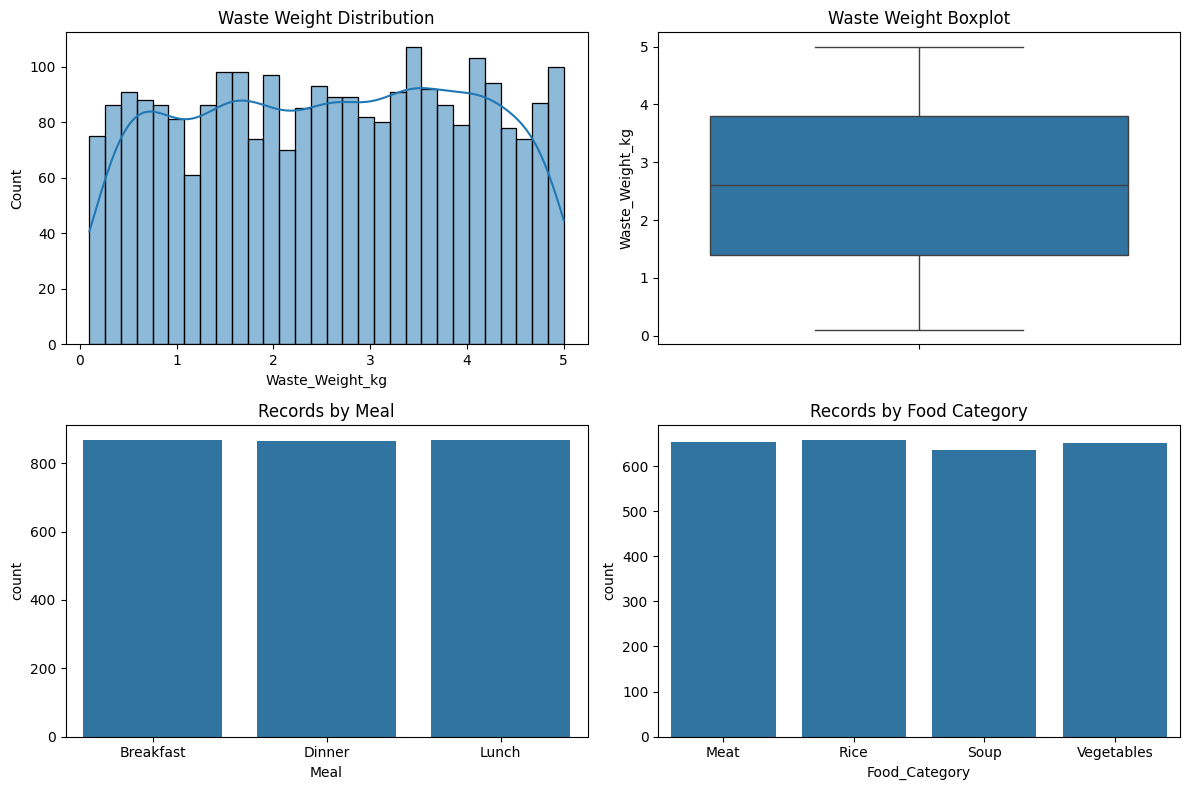


Summary plots saved as 'cleaning_summary_plots.png'


In [15]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(df['Waste_Weight_kg'], bins=30, kde=True, ax=axes[0,0])
axes[0,0].set_title('Waste Weight Distribution')
sns.boxplot(y=df['Waste_Weight_kg'], ax=axes[0,1])
axes[0,1].set_title('Waste Weight Boxplot')
sns.countplot(data=df, x='Meal', ax=axes[1,0])
axes[1,0].set_title('Records by Meal')
sns.countplot(data=df, x='Food_Category', ax=axes[1,1])
axes[1,1].set_title('Records by Food Category')
plt.tight_layout()
plt.savefig('cleaning_summary_plots.png')
plt.show()
print("\nSummary plots saved as 'cleaning_summary_plots.png'")